# FitzHugh-Nagumoモデル

## FitzHugh-Nagumoモデルの定義

$$
\begin{align*} \frac{dv}{dt} &= c\left(v-\frac{v^3}{3}-u+I_e\right)\\ 
\frac{du}{dt} &= v-bu+a \end{align*}
$$

ここで$a,b,c$は定数であり，$a=0.7, b=0.8, c=10$がよく使われる．$v$は膜電位で，$u$は回復変数(recovery variable)である． $I_e$は外部刺激電流に対応する．

まず必要なパッケージを読み込む．

In [1]:
using Base: @kwdef
using Parameters: @unpack # or using UnPack
using PyPlot

変更しない定数を保持する `struct` の `FHNParameter` と, 変数を保持する `mutable struct` の `FHN` を作成する．

In [2]:
@kwdef struct FHNParameter{FT}
    a::FT = 0.7
    b::FT = 0.8
    c::FT = 10.0
end

@kwdef mutable struct FHN{FT}
    param::FHNParameter = FHNParameter{FT}()
    N::UInt16
    v::Vector{FT} = fill(-1.0, N)
    u::Vector{FT} = zeros(N)
end

次に変数を更新する関数`update!`を書く．ソルバーとしては陽的Euler法または4次のRunge-Kutta法を用いる．以下ではEuler法を用いている．Juliaではforループを用いて1つのニューロンごとにパラメータを更新する方がベクトルを用いるよりも高速である．

In [3]:
function update!(variable::FHN, param::FHNParameter, Ie::Vector, dt)
    @unpack N, v, u = variable
    @unpack a, b, c = param
    @inbounds for i = 1:N
        v[i] += dt * c * (-u[i] + v[i] - v[i]^3 / 3 + Ie[i])
        u[i] += dt * (v[i] - b*u[i] + a)
    end
end

update! (generic function with 1 method)

## FitzHugh-Nagumoモデルのシミュレーションの実行
いくつかの定数を設定してシミュレーションを実行する．

In [4]:
T = 50 # ms
dt = 0.01f0 # ms
nt = UInt32(T/dt) # number of timesteps
N = 1 # ニューロンの数

# 入力刺激
t = Array{Float32}(1:nt)*dt
Ie = repeat(0.35f0*ones(nt), 1, N)  # injection current

# 記録用
varr, uarr = zeros(Float32, nt, N), zeros(Float32, nt, N)

# modelの定義
neurons = FHN{Float32}(N=N)

# simulation
@time for i = 1:nt
    update!(neurons, neurons.param, Ie[i, :], dt)
    varr[i, :], uarr[i, :] = neurons.v, neurons.u
end

  0.074491 seconds (249.93 k allocations: 12.892 MiB, 93.39% compilation time)


結果を描画する．

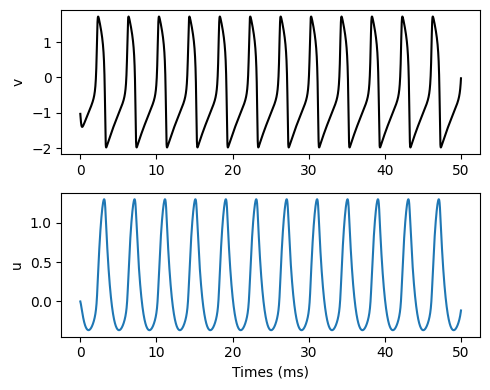

In [5]:
figure(figsize=(5,4))
subplot(2, 1, 1); plot(t, varr[:, 1], label=false, color="black"); ylabel("v")
subplot(2, 1, 2); plot(t, uarr[:, 1], label=false); ylabel("u"); xlabel("Times (ms)")
tight_layout()

発火回数を求める．

In [6]:
spike = (varr[1:nt-1, :] .< 0) .& (varr[2:nt, :] .> 0)
num_spikes = sum(spike, dims=1)
println("Num. of spikes : ", num_spikes[1]);

Num. of spikes : 12


## 相図の描画

In [7]:
margin = 1.0
vmax, vmin = maximum(varr) + margin, minimum(varr) - margin
umax, umin = maximum(uarr) + margin, minimum(uarr) - margin
vrange, urange = vmin:0.1:vmax, umin:0.1:umax
U = [i for i in urange, j in 1:length(vrange)]
V = [j for i in 1:length(urange), j in vrange]

a, b, c, Ie = 0.7, 0.8, 10.0, 0.34
dV = c * (-U + V - V .^3 / 3 .+ Ie)
dU = V - b*U .+ a;

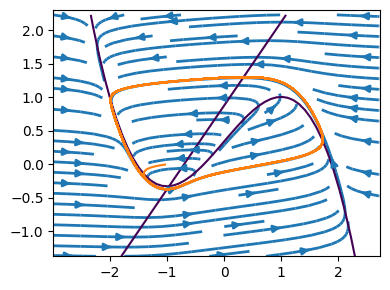

In [8]:
figure(figsize=(4,3))
streamplot(V, U, dV, dU, density=[0.8, 0.8], linewidth=2) 
contour(V, U, dU, levels=[0])
contour(V, U, dV, levels=[0])
plot(varr, uarr); xlim(vmin, vmax); ylim(umin, umax)
tight_layout()